In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import skewnorm
import scipy.stats as stats  
from sklearn.preprocessing import LabelEncoder
from pandas_profiling import ProfileReport
import pylab as p  
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In C:\Users\frees\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\frees\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\frees\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\frees\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\frees\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
df=pd.read_excel("Online Retail.xlsx",sheet_name='Online Retail')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [6]:
#Perform descriptive analytics on the given data
profile = ProfileReport(df, title='Retail_Profiling_Report')

In [9]:
profile.to_file("Retail_Profiling_Report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Data Cleaning

In [10]:
#missing Data and formulate an apt strategy to treat them
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [11]:
df.dropna(subset=['CustomerID'], inplace=True)

In [12]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [13]:
#Remove duplicate data records
df.drop_duplicates(inplace = True)

In [14]:
df.duplicated().sum()

0

Data Transformation

In [15]:
#Cohort Analysis
df['order_month'] = df['InvoiceDate'].dt.to_period('M')
df['cohort'] = df.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M') 
df_cohort=pd.DataFrame(df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)) 

In [16]:
df_cohort.head()

,cohort,order_month,n_customers
0,2010-12,2010-12,948
1,2010-12,2011-01,362
2,2010-12,2011-02,317
3,2010-12,2011-03,367
4,2010-12,2011-04,341


In [17]:
#Active customer each Cohort
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
df_cohort.head()

,cohort,order_month,n_customers,period_number
0,2010-12,2010-12,948,0
1,2010-12,2011-01,362,1
2,2010-12,2011-02,317,2
3,2010-12,2011-03,367,3
4,2010-12,2011-04,341,4


In [18]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

In [20]:
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


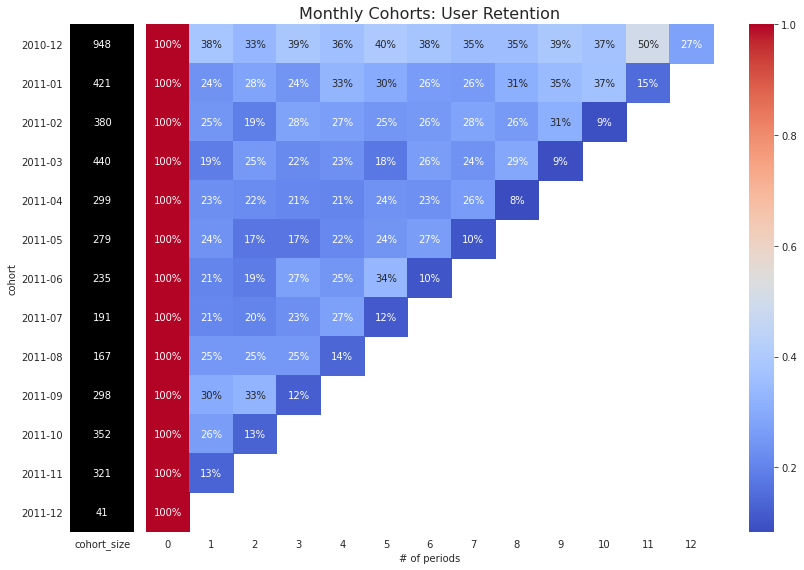

In [26]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='coolwarm',
                #cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['black'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

# Week 2

In [27]:
#Build RFM model
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [28]:
#RFM metrics
latestdate = dt.datetime(2011,12,10)
rfmtable=df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (latestdate - x.max()).days, 'InvoiceNo': lambda x: len(x),'UnitPrice': lambda x: x.sum()})
rfmtable=rfmtable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'UnitPrice': 'monetary_value'})
rfmtable

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,2,2.08
12347.0,2,182,481.21
12348.0,75,31,178.71
12349.0,18,73,605.10
12350.0,310,17,65.30
...,...,...,...
18280.0,277,10,47.65
18281.0,180,7,39.36
18282.0,7,13,62.68


RFM segments
Quantile

In [29]:
quantiles = rfmtable.quantile(q=[0.25,0.5,0.75])
quantiles.to_dict()

{'recency': {0.25: 16.0, 0.5: 50.0, 0.75: 143.0},
 'frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.25},
 'monetary_value': {0.25: 52.730000000000004, 0.5: 128.925, 0.75: 299.0975}}

In [30]:
segmented_rfm = rfmtable

In [31]:
def recencyscore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4
    
def fmscore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1 

Type Markdown and LaTeX:  𝛼2

In [32]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(recencyscore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(fmscore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(fmscore, args=('monetary_value',quantiles,))


segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,325,2,2.08,4,4,4
12347.0,2,182,481.21,1,1,1
12348.0,75,31,178.71,3,3,2
12349.0,18,73,605.10,2,2,1
12350.0,310,17,65.30,4,4,3


In [33]:
segmented_rfm.to_csv('SegmentedRFM.csv')
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str)+segmented_rfm.f_quartile.map(str)+segmented_rfm.m_quartile.map(str)

segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
12346.0,325,2,2.08,4,4,4,444
12347.0,2,182,481.21,1,1,1,111
12348.0,75,31,178.71,3,3,2,332
12349.0,18,73,605.10,2,2,1,221
12350.0,310,17,65.30,4,4,3,443


In [34]:
#Customer Segementation according to RFM
pd.set_option("display.max_colwidth", 10000)
data = {'Customer Segement':['Best Customers', 'Loyal Customers', 'Big Spender', 'Almost Lost','Lost Customers','Lost Cheap Customers'], 'RFM':['111', 'X1X', 'XX1', '311','411','444'],'Desrciption':['Bought Most Recently and More Often', 'Buy Most Frequently', 'Spend The Most', 'Did not purchased for some time but purchased frequently and most','Did not purchased for some time but purchased frequently and most','Last purchased long ago,purchased few and spent little']}
pd.DataFrame(data)

,Customer Segement,RFM,Desrciption
0,Best Customers,111,Bought Most Recently and More Often
1,Loyal Customers,X1X,Buy Most Frequently
2,Big Spender,XX1,Spend The Most
3,Almost Lost,311,Did not purchased for some time but purchased frequently and most
4,Lost Customers,411,Did not purchased for some time but purchased frequently and most
5,Lost Cheap Customers,444,"Last purchased long ago,purchased few and spent little"


# Week 3

Clustering using K-mean

In [35]:
cluster = segmented_rfm
cluster = cluster.reset_index(level=0).iloc[:,[2,3]].values

pd.DataFrame(cluster)

,0,1
0,2.0,2.08
1,182.0,481.21
2,31.0,178.71
3,73.0,605.10
4,17.0,65.30
...,...,...
4367,10.0,47.65
4368,7.0,39.36
4369,13.0,62.68
4370,721.0,1174.33


In [36]:
sc= StandardScaler()
cluster = sc.fit_transform(cluster)

C:\Users\frees\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

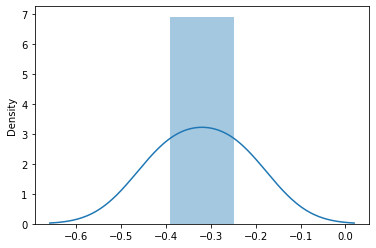

In [37]:
sns.distplot(cluster[0])

C:\Users\frees\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

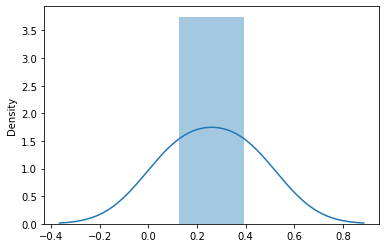

In [38]:
sns.distplot(cluster[1])

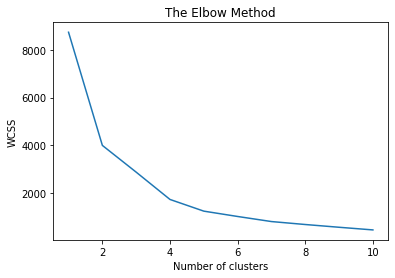

In [39]:
#WCSS
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(cluster)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

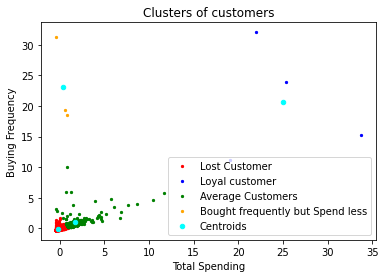

In [45]:
#Optimum number of clusters to be formed is 4
kmeans = KMeans(n_clusters = 4, init = 'k-means++')
y_kmeans = kmeans.fit_predict(cluster)
plt.scatter(cluster[y_kmeans == 0, 0], cluster[y_kmeans == 0, 1], s = 5, c = 'red', label = 'Lost Customer')
plt.scatter(cluster[y_kmeans == 1, 0], cluster[y_kmeans == 1, 1], s = 5, c = 'blue', label = 'Loyal customer')
plt.scatter(cluster[y_kmeans == 2, 0], cluster[y_kmeans == 2, 1], s = 5, c = 'green', label = 'Average Customers')
plt.scatter(cluster[y_kmeans == 3, 0], cluster[y_kmeans == 3, 1], s = 5, c = 'orange', label = 'Bought frequently but Spend less')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 20, c = 'cyan', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Total Spending')
plt.ylabel('Buying Frequency')
plt.legend()
plt.show()